<a href="https://colab.research.google.com/github/BoKna031/Image_inpainting/blob/master/Image_inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to Kaggle dataset

In [1]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets list

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d amanara/photos
!unzip photos.zip;

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (1252).jpeg  
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (1253).jpeg  
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (1254).jpeg  
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (1255).jpeg  
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (1256).jpeg  
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (1257).jpeg  
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (126).jpeg  
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (1260).jpeg  
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (1261).jpeg  
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (1262).jpeg  
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Tr

# Hyperparameters

In [64]:
#----------------DATA-----------------

ORG_IMG_SIZE = (256,256)
SCALED_IMG_SIZE = (64, 64)
MASK_BOX_SIZE = [15, 15]

#----------------CNN------------------

CNN_BATCH_SIZE = 16
CNN_EPOCH = 5

CNN_TRAIN_AND_SAVE_MODEL = False
CNN_LOAD_MODEL = True

CNN_MODEL_DIRECTORY_PATH = "/content/drive/MyDrive/Colab Notebooks/ImageInpainting/CNN/trained-models"
CNN_MODEL_FILENAME = "euclidean_model_1.keras"
CNN_HISTORY_DIRECTORY_PATH = "/content/drive/MyDrive/Colab Notebooks/ImageInpainting/CNN/history"
CNN_HISTORY_FILENAME = "euclidean_model_64_history.pkl"

# Data preparation

In [36]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt

TRAIN = 'Train'
TEST = 'Test'

def load_training_dataset(category):
  TRAINING_DATA_FOLDER = os.path.join('Dataset', 'Training_Data', category)
  x_doc = os.path.join('Dataset', 'Training_Data', category, 'Masked_Train')
  x_imgs = _load_images_from_folder(x_doc, category, TRAIN)
  y_doc = os.path.join('Dataset', 'Training_Data', category, 'Unmasked_Train')
  y_imgs = _load_images_from_folder(y_doc, category, TRAIN)
  csv_file = pd.read_csv(os.path.join(TRAINING_DATA_FOLDER, 'masked_info.csv'))
  adjust_box_coordinate(csv_file)
  return x_imgs, y_imgs, csv_file

def adjust_box_coordinate(csv_df):
  scale_xy = SCALED_IMG_SIZE[0] / ORG_IMG_SIZE[0]
  csv_df[['box1_row', 'box1_col', 'box2_row', 'box2_col']] = (csv_df[['box1_row', 'box1_col', 'box2_row', 'box2_col']] * scale_xy).astype(int)


def _load_images_from_folder(folder, category, set_type):
    images = []
    for filename in os.listdir(folder):
            img = cv2.imread(os.path.join(folder, filename))
            img = cv2.resize(img, SCALED_IMG_SIZE)
            if img is not None:
              id, format = _parse_filename(filename)
              images.append({'filename': filename, 'category': category, 'id': id, 'set_type': set_type, 'format': format, 'image': img})
    images_df = pd.DataFrame(images, columns=['filename', 'category', 'id', 'set_type', 'format', 'image'])
    return images_df

import re

def _parse_filename(filename):
    regex_pattern = r'.*\((\d+)\)\.(\w+)$'

    match = re.match(regex_pattern, filename)

    if match:
        id = int(match.group(1))
        format =  match.group(2)
        return id, format
    else:
        return  None, None

def show_img(img, gray = False):
  if gray:
    plt.imshow(img, 'gray')
  else:
    plt.imshow(img)
  plt.axis('off')
  plt.show()


In [37]:
categories = ['Cat', 'Dog', 'Elephant', 'Tiger']

# Data analyzing

In [6]:
category = categories[0]
_, y, csv = load_training_dataset(category)
x_size = y['image'].apply(lambda img: pd.Series({'rows':img.shape[0], 'cols': img.shape[1]})).groupby(['rows','cols']).size()
print(f"{category}\n---------------------------")
print("total size = ",y.shape[0])
print(x_size)

Cat
---------------------------
total size =  1750
rows  cols
64    64      1750
dtype: int64


From the shown, it can be seen that all the images are of size 168x168

In [7]:
csv.head()

,Unnamed: 0,filename,box1_row,box1_col,box2_row,box2_col
0,0,Cat-Train (1085).jpeg,16,1,10,38
1,1,Cat-Train (900).jpeg,21,5,26,41
2,2,Cat-Train (1759).jpeg,15,24,0,35
3,3,Cat-Train (969).jpeg,3,34,11,34
4,4,Cat-Train (1559).jpeg,26,23,10,39


In [8]:
def is_within_bounds(row, col):
  return row + MASK_BOX_SIZE[0] <= SCALED_IMG_SIZE[0] and col + MASK_BOX_SIZE[1] <= SCALED_IMG_SIZE[1]

In [9]:
csv['box1_within_bounds'] = csv.apply(lambda row: is_within_bounds(row['box1_row'], row['box1_col']), axis=1)
csv['box2_within_bounds'] = csv.apply(lambda row: is_within_bounds(row['box2_row'], row['box2_col']), axis=1)
invalid_boxes = csv[(~csv['box1_within_bounds']) | (~csv['box2_within_bounds'])]

In [10]:
csv.head()

,Unnamed: 0,filename,box1_row,box1_col,box2_row,box2_col,box1_within_bounds,box2_within_bounds
0,0,Cat-Train (1085).jpeg,16,1,10,38,True,True
1,1,Cat-Train (900).jpeg,21,5,26,41,True,True
2,2,Cat-Train (1759).jpeg,15,24,0,35,True,True
3,3,Cat-Train (969).jpeg,3,34,11,34,True,True
4,4,Cat-Train (1559).jpeg,26,23,10,39,True,True


In [11]:
print(f"There is {invalid_boxes.shape[0]} images that have invalid boxes")

There is 0 images that have invalid boxes


In [12]:
x_cp = y.copy(deep=True)

In [13]:
def img_normalize(image_orig, min_norm, max_norm):
    val_max = 255.0
    val_min = 0.0
    range = val_max - val_min
    image_normalized = (image_orig - val_min) / range
    range2 = max_norm - min_norm
    image_normalized = (image_normalized*range2) + min_norm
    return image_normalized

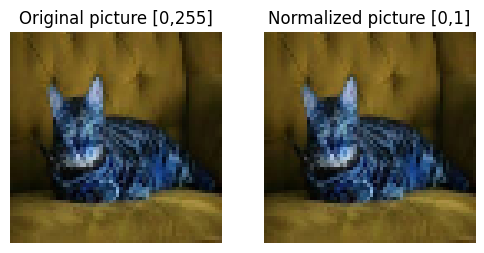

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(6, 10))
axes[0].imshow(x_cp.iloc[0]['image'][:,:,:3])
axes[0].set_title('Original picture [0,255]')
axes[0].axis('off')
axes[1].imshow(img_normalize(x_cp.iloc[0]['image'], 0, 1))
axes[1].set_title('Normalized picture [0,1]')
axes[1].axis('off')
plt.show()

In [15]:
import numpy as np
def draw_masks(image, csv_row , box_size):
    col1, row1, col2, row2 = csv_row['box1_col'], csv_row['box1_row'], csv_row['box2_col'], csv_row['box2_row']

    mask = np.zeros(SCALED_IMG_SIZE)
    mask[row1:row1+box_size[0], col1:col1+box_size[1]] = 1
    img_cp = image.copy()

    #gaussian
    gaussian_noise = np.random.normal(0, 1, img_cp.shape)
    mean_pixel_value = np.mean(image, axis=(0, 1), keepdims=True)
    noise_centered_at_mean = mean_pixel_value + gaussian_noise

    img_cp[mask == 1] = gaussian_noise[mask == 1]

    img_cp = img_normalize(img_cp, 0, 1)

    mask = mask[:, :, np.newaxis]
    rgbm_image = np.concatenate((img_cp, mask), axis=2)

    return rgbm_image

In [16]:
x_cp['image'] = x_cp.apply(lambda row: draw_masks(row['image'], csv[csv['filename'] == row['filename']].iloc[0], MASK_BOX_SIZE), axis = 1)

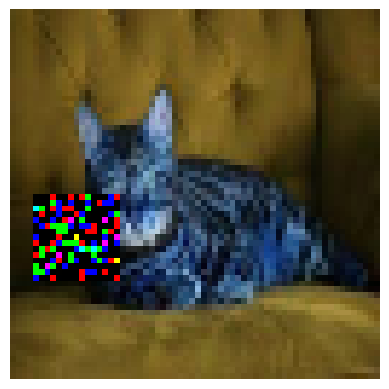

In [17]:
show_img(x_cp.iloc[0]['image'][:,:,:3])

In [18]:
merged_data = pd.merge(x_cp, csv, on='filename')
merged_data = pd.merge(merged_data, y, on = 'filename')

In [19]:
final_table_columns = ['filename', 'image_x', 'image_y', 'box2_row', 'box2_col']
train_df = merged_data.drop(columns=[col for col in merged_data if col not in final_table_columns])

In [20]:
def crop_box(rgbm, y_img):
  mask = rgbm[:,:,3]
  rows, cols = np.where(mask == 1)

  min_row, max_row = np.min(rows), np.max(rows)
  min_col, max_col = np.min(cols), np.max(cols)

  return y_img[min_row:max_row + 1, min_col:max_col + 1, :]


In [21]:
train_df['image_y'] = img_normalize(train_df['image_y'], 0, 1)
train_df['image_y_crop'] = train_df.apply(lambda row: crop_box(row['image_x'], row['image_y']), axis = 1)

# Networks

In [22]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Activation, Reshape
from tensorflow.keras.models import Sequential

## CNN

In [23]:
euclidean_model_1 = Sequential()

euclidean_model_1.add(Conv2D(64, kernel_size=3, activation='relu', padding='same', input_shape=(SCALED_IMG_SIZE[0], SCALED_IMG_SIZE[1], 4)))
for i in range(9):
  if (i + 1) % 3 == 0:
     euclidean_model_1.add(Conv2D(64, kernel_size=3, padding='same', strides=2, activation='relu'))
  else:
    euclidean_model_1.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))

euclidean_model_1.add(Flatten())
euclidean_model_1.add(Dense(MASK_BOX_SIZE[0]*MASK_BOX_SIZE[1]*3, activation='relu'))
euclidean_model_1.add(Activation('sigmoid'))
euclidean_model_1.compile(loss='mse', optimizer='adam', metrics=['mae'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import backend as K


def lr_schedule(epoch):
    model = euclidean_model_1
    lr = model.optimizer.learning_rate.numpy()
    if epoch % 5 == 0 and epoch > 0:
        new_lr = lr * 0.8
        model.optimizer.learning_rate.assign(new_lr)
        print(f"Learning rate reduced to: {new_lr}")
    return model.optimizer.learning_rate.numpy()

In [26]:
lr_scheduler = LearningRateScheduler(lr_schedule)
batch_size = CNN_BATCH_SIZE
epochs = CNN_EPOCH

In [27]:
X_train = np.stack(train_df['image_x'].values)
y_train = np.stack(train_df['image_y_crop'].values)
y_train = y_train.reshape(y_train.shape[0],MASK_BOX_SIZE[0]*MASK_BOX_SIZE[1]*3)

In [28]:
print('x: ', np.max(X_train))
print('y: ', np.max(y_train))

x:  1.0
y:  1.0


In [40]:
import pickle

def save_history(history, path):
  with open(path, 'wb') as f:
    pickle.dump(history, f)

In [53]:
if CNN_TRAIN_AND_SAVE_MODEL:
  history = euclidean_model_1.fit(
      X_train, y_train,
      batch_size=batch_size,
      epochs=epochs,
      callbacks=[lr_scheduler],
      validation_split=0.2
  )

  euclidean_model_1.save(CNN_MODEL_DIRECTORY_PATH + "/" + CNN_MODEL_FILENAME)
  save_history(history.history, CNN_HISTORY_DIRECTORY_PATH + "/" + CNN_HISTORY_FILENAME)
else:
  print("Training and saving the model is skipped")


Training and saving the model is skipped


# Monitoring - History of loss function

In [43]:
def load_history(path):
  with open(path, "rb") as file:
    return pickle.load(file)

In [54]:
h1 = load_history(CNN_HISTORY_DIRECTORY_PATH + "/" + CNN_HISTORY_FILENAME)

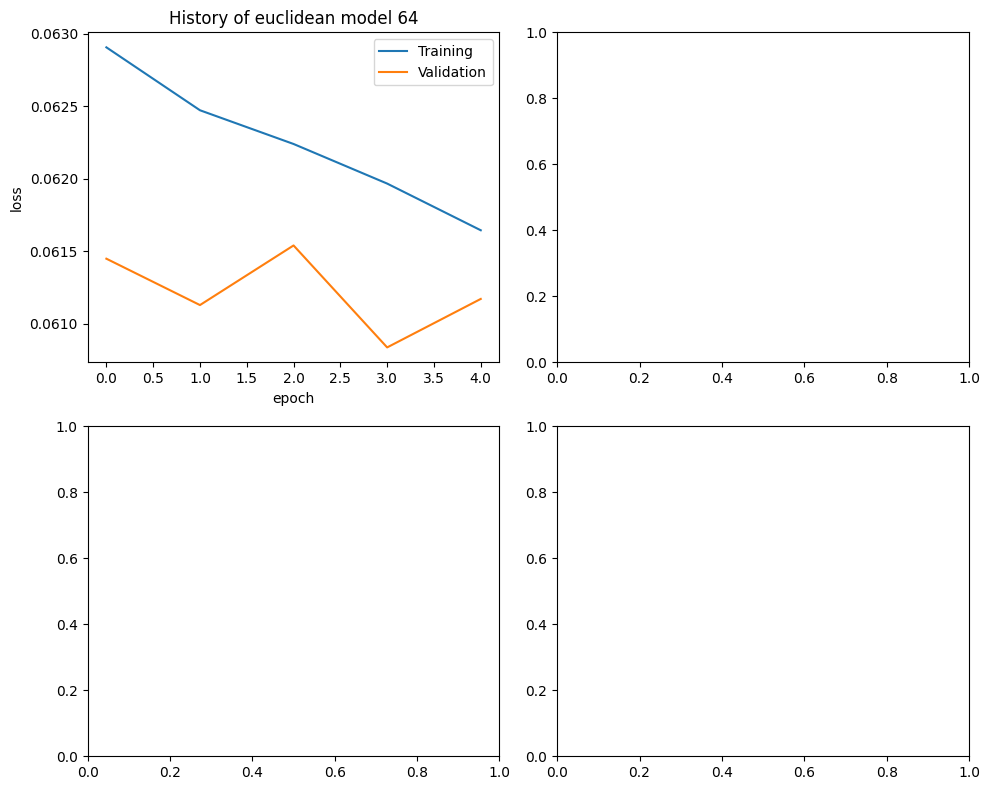

In [55]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes[0, 0].plot(h1['loss'])
axes[0, 0].plot(h1['val_loss'])
axes[0, 0].set_title('History of euclidean model 64')
axes[0, 0].set_xlabel('epoch')
axes[0, 0].set_ylabel('loss')
axes[0, 0].legend(['Training', 'Validation'])
plt.tight_layout()
plt.show()

# Predictions

In [59]:
from keras.models import load_model

loaded_model = load_model(CNN_MODEL_DIRECTORY_PATH + "/" + CNN_MODEL_FILENAME)

In [57]:
x = X_train[0:5]

In [60]:
pred = loaded_model.predict(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


In [61]:
def full_image(x_rgbm_img, y_img):
  modified_image = np.copy(x_rgbm_img[:, :, :3])
  mask = x_rgbm_img[:,:,3]

  coords = np.argwhere(mask == 1)

  x_min = np.min(coords[:, 0])
  y_min = np.min(coords[:, 1])

  modified_image[x_min : x_min + MASK_BOX_SIZE[0], y_min : y_min+ MASK_BOX_SIZE[1], :] = y_img

  return modified_image

def reconstruct_img(data):
  if sum(data.shape) == 675:
    return np.reshape(data, (MASK_BOX_SIZE[0], MASK_BOX_SIZE[1], 3))
  else:
    num_samples = data.shape[0]
    return y_train.reshape(num_samples, MASK_BOX_SIZE[0], MASK_BOX_SIZE[1], 3)

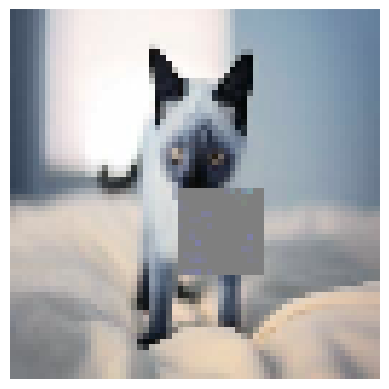

In [62]:
img_ind = 2
show_img(full_image(x[img_ind],reconstruct_img(pred[img_ind])))

# GAN

In [ ]:
import torch
from torch import nn

import math
torch.manual_seed(42)

In [ ]:
y_train.shape

(1750, 675)

In [ ]:
X_train.shape

(1750, 64, 64, 4)

In [ ]:
train_data = torch.tensor(X_train)
y_train_gan = np.stack(train_df['image_y'].values)
num_samples = X_train.shape[0]
train_labels = torch.tensor(y_train_gan, dtype=torch.float32).view(num_samples, -1)
train_set = [
    (train_data[i], train_labels[i]) for i in range(num_samples)
]

# GAN GPT

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import numpy as np

In [66]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=4, stride=2, padding=1),  # Input is 64x64x4
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output is 32x32x128
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Output is 16x16x256
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # Output is 8x8x512
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # Output is 16x16x256
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Output is 32x32x128
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output is 64x64x64
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),  # Output is 64x64x3
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # Input is 64x64x3
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output is 32x32x128
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Output is 16x16x256
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # Output is 8x8x512
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=1),  # Output is 4x4x1
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x


In [71]:
class InpaintingDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images  # Should be 64x64x4 images (3 channels for RGB + 1 channel for the mask)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Split the image into RGB and mask channels
        image = self.images[idx, :, :, :3]  # Extract the RGB channels
        mask = self.images[idx, :, :, 3]  # Extract the mask channel

        masked_image = image * mask[..., None]  # Apply the mask to the RGB image (expand mask to 3 channels)

        # Convert to tensors and normalize if a transform is provided
        if self.transform:
            masked_image = self.transform(masked_image)
            image = self.transform(image)
            mask = torch.from_numpy(mask).unsqueeze(0).float()  # Convert mask to tensor and add a channel dimension

        # Concatenate the mask as the 4th channel
        input_image = torch.cat((masked_image, mask), dim=0)

        return input_image, image

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = InpaintingDataset(X_train, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 50

for epoch in range(num_epochs):
    for i, (input_images, real_images) in enumerate(dataloader):
        real_images = real_images.to(device).float()
        input_images = input_images.to(device).float()

        # Generate inpainted images
        fake_images = generator(input_images)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(real_images.size(0), 1).to(device)
        fake_labels = torch.zeros(real_images.size(0), 1).to(device)

        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)

        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizer_G.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(dataloader)}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")


ValueError: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 1, 2, 2])) is deprecated. Please ensure they have the same size.